In [1]:
import pandas as pd

In [2]:
tab1 = pd.read_csv("../tabs/table_1.csv")
tab1.rename(columns={"Models": "Model", 
                     "Complete Test set": "Test Set", 
                     "3k weighted unique random": "Weighted Random (3k)",
                     "Bottom - 3k": "Bottom-3k"}, inplace = True)
tab1.drop("3k unique random", axis = 1, inplace = True)
tab1 = tab1.round(2)
tab1

,Model,Test Set,Weighted Random (3k),Top-3k,Bottom-3k
0,RNN,64.8,65.50,64.6,62.03
1,LSTM,74.8,74.10,70.9,73.20
2,GRU,81.3,81.23,77.4,79.80


In [3]:
tab1_style = tab1.style
tab1_style.format(subset=["Test Set", "Weighted Random (3k)", "Top-3k", "Bottom-3k"], precision=1)\
        .format_index(escape="latex", axis=1)\
        .format_index(escape="latex", axis=0)\
        .hide(level=0, axis=0)  
tab1_tex = tab1_style.to_latex(caption = "Accuracy of Different Models on the Test Set",
                               clines="skip-last;data",
                               convert_css=True,
                               label = "model_comparison",
                               position_float="centering",
                               multicol_align="|c|",
                               hrules=True)

In [4]:
f = open("../tabs/model_comparison.tex", "w")
f.write(tab1_tex)
f.close()

In [5]:
tab2 = pd.read_csv("../tabs/table_2.csv")
tab2["States"] = tab2["States"].str.capitalize()
tab2.loc[(tab2['States']=='Guj'), 'States'] = 'Gujarat'
tab2.loc[(tab2['States']=='Andhra'), 'States'] = 'Andhra Pradesh'
tab2.loc[(tab2['States']=='Har'), 'States'] = 'Haryana'
tab2.loc[(tab2['States']=='Jha'), 'States'] = 'Jharkhand'
tab2.loc[(tab2['States']=='Kar'), 'States'] = 'Karnataka'
tab2.loc[(tab2['States']=='Mp'), 'States'] = 'Madhya Pradesh'
tab2.loc[(tab2['States']=='Jk'), 'States'] = 'Jammu and Kashmir'
tab2.rename(columns={"States": "State", 
                     "1-NN w/ Edit Distance": "1-NN"}, 
            inplace = True)
tab2

,State,1-NN,RNN,LSTM,GRU
0,Andaman,14.661879,16.480,20.825853,69.56
1,Andhra Pradesh,79.720930,43.440,55.503876,62.97
2,Arunachal,28.310078,70.200,73.643411,69.02
3,Assam,16.713178,53.080,93.643411,95.31
4,Bihar,31.720930,0.490,5.457364,3.68
5,Chandigarh,1.302326,88.060,80.899225,42.23
6,Dadra,28.899225,44.310,71.131783,73.08
7,Daman,12.806202,21.920,42.666667,62.69
8,Delhi,63.937984,49.890,16.837209,33.58
9,Goa,27.844961,24.620,40.062016,43.93


In [6]:
tab2_style = tab2.style
tab2_style.format(subset=["1-NN", "RNN", "LSTM", "GRU"], precision=1)\
        .format_index(escape="latex", axis=1)\
        .format_index(escape="latex", axis=0)\
        .hide(level=0, axis=0)  
tab2_tex = tab2_style.to_latex(caption = "Accuracy of Different Models By State of Residence",
                               clines="skip-last;data",
                               convert_css=True,
                               label = "accuracy_by_state",
                               position_float="centering",
                               multicol_align="|c|",
                               hrules=True)

In [7]:
f = open("../tabs/accuracy_by_state.tex", "w")
f.write(tab2_tex)
f.close()

In [8]:
import numpy as np
import scipy
import matplotlib                 # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
import statsmodels

In [9]:
lstm = pd.read_csv("../out/lstm_pred.csv")
lstm['total_freq_log'] = np.log2(lstm['total_freq'])

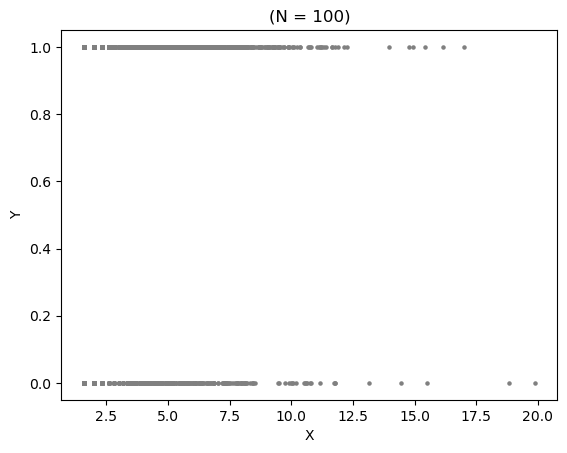

In [10]:
plt.scatter(lstm["total_freq_log"], lstm["lstm_pred"], color="grey", marker="o", s=5)
plt.xlabel("X"), plt.ylabel("Y")
plt.title('(N = 100)')
plt.show()

In [ ]:

def loc_eval(x, b):
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)

def loess(xvals, yvals, data, alpha, poly_degree=1):
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)
    evalDF = pd.DataFrame(columns=['v','g'])
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = min(xvals)-(.5*avg_interval)
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T
    for i in v:
        iterpos = i[0]
        iterval = i[1]
        iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
        _, raw_dists = zip(*iterdists)
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 if j[1]<=1 else 0)) for j in scaled_dists]
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))
        W         = np.diag(weights)
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ yvals)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })
        evalDF = pd.concat([evalDF, iterDF2])
    evalDF = evalDF[['v','g']]
    return(evalDF)


evalDF = loess("total_freq_log", "lstm_pred", data = lstm, alpha=0.7, poly_degree=2)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(lstm["total_freq_log"], lstm["lstm_pred"], alpha = .3, color="grey", marker="o", s=5, label="_nolegend_")
ax1.plot(evalDF['v'], evalDF['g'], color='red', linewidth= 3, label="Test")
plt.title('N = 10, alpha = 0.7, polynomial degree = 2')
plt.legend()
plt.tight_layout()
plt.savefig("popularity_performance.png")
plt.show()